<a href="https://colab.research.google.com/github/samyaknd/phishing-email-classifier/blob/main/phishing_email_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier

# 1. Data Loading and Cleaning

In [20]:
#Loading data
raw_data = pd.read_csv('/content/Dataset/Phishing_Email.csv')
raw_data.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [22]:
raw_data.dtypes
raw_data.info()
df_raw = raw_data.where(pd.notnull(raw_data), '')
df_raw.drop(columns=['Unnamed: 0'],inplace=True)
df_raw.shape
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


The original dataset has more that 50,000 rows. I have created my model on 10,000 rows in order to save time and resources. I have sampled 10,000 randon rows in the below step.

---



In [23]:
df_raw.rename(columns={'Email Text': 'text', 'Email Type': 'target'}, inplace=True)
df_raw.sample(5)
df = df_raw.sample(n=10000, random_state=42)
df.reset_index(drop=True, inplace=True)
df.head()

,text,target
0,"Once upon a time, Harri wrote :> Title page ha...",Safe Email
1,new books : generative studies we would like t...,Safe Email
2,new book : japanese linguistics japanese lingu...,Safe Email
3,renewal notice for your domain name ( s ) dear...,Safe Email
4,hot stock tip your broker won ' t share now th...,Phishing Email


First, I needed to convert the categories in my dataset's target variable into numbers, as most machine learning models work better with numerical data. So, I used a LabelEncoder to do this conversion. After encoding Phishing Email = 0 and Safe Email = 1

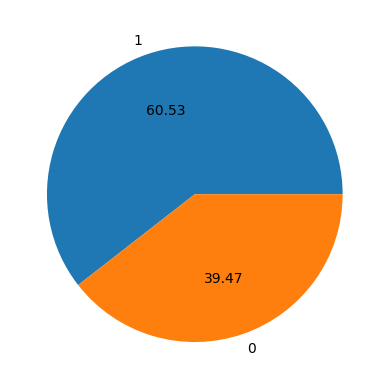

,text,target
0,"Once upon a time, Harri wrote :> Title page ha...",1
1,new books : generative studies we would like t...,1
2,new book : japanese linguistics japanese lingu...,1
3,renewal notice for your domain name ( s ) dear...,1
4,hot stock tip your broker won ' t share now th...,0


In [24]:
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])
plt.pie(df['target'].value_counts(), labels=['1','0'],autopct="%0.2f")
plt.show()
df.head()

# 2. EDA:

I am going to do some feature extraction to better under the data. I used the NLTK punkt tokenizer to  split text into sentences. This tokenizer is needed for subsequent calculations involving sentence counts.

These features help me understand the characteristics of emails in the dataset (length, complexity, etc.) and potentially identify patterns related to the target variable (phishing vs safe emails).

In [25]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [26]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,text,target,num_characters,num_words,num_sentences
0,"Once upon a time, Harri wrote :> Title page ha...",1,772,120,3
1,new books : generative studies we would like t...,1,2366,491,22
2,new book : japanese linguistics japanese lingu...,1,1155,216,12
3,renewal notice for your domain name ( s ) dear...,1,3025,637,41
4,hot stock tip your broker won ' t share now th...,0,8813,1657,64


Now I will look at the summary statistics for the newly created features (num_characters, num_words, and num_sentences). It give me a feel of the central tendency, spread, and potential outliers in the distribution of these features for different email categories.

In [27]:
phishing_stats = df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()
pd.options.display.float_format = '{:.2f}'.format
print("\nStatistics for Phishing Emails:")
print(phishing_stats)
average_num_words = df[df['target'] == 0]['num_words'].mean()
print(f"\n\nAverage number of words in phishing emails: {average_num_words:.2f}")
pd.options.display.float_format = None  # Resets to default format



Statistics for Phishing Emails:
       num_characters  num_words  num_sentences
count         3947.00    3947.00        3947.00
mean          1625.94     327.94          19.39
std           3309.19     673.41          36.66
min              0.00       0.00           0.00
25%            353.00      72.00           5.00
50%            725.00     143.00          10.00
75%           1530.00     304.50          19.00
max          72743.00   13291.00         510.00


Average number of words in phishing emails: 327.94


In [34]:
safe_stats = df[df['target'] == 1][['num_characters','num_words','num_sentences']].describe()
pd.options.display.float_format = '{:.2f}'.format
print("\nStatistics for Safe Emails:")
print(safe_stats)
average_num_words_safe = df[df['target'] == 1]['num_words'].mean()
print(f"\n\nAverage number of words in safe emails: {average_num_words_safe:.2f}")
pd.options.display.float_format = None  # Resets to default format



Statistics for Safe Emails:
       num_characters  num_words  num_sentences
count         6053.00    6053.00        6053.00
mean          1974.80     400.43          20.73
std           4772.43     924.57          59.08
min              5.00       1.00           1.00
25%            442.00      90.00           4.00
50%            991.00     206.00           9.00
75%           2016.00     415.00          18.00
max         120761.00   23343.00        1511.00


Average number of words in safe emails: 400.43


**Observations:**

**Overall Length:**\
Safe emails tend to be somewhat longer on average compared to phishing emails. This is evident from the mean values for num_characters.

**Word Count:**\
Safe emails also have a higher average word count than phishing emails.

**Sentence Structure:**\
Both safe and phishing emails seem to have a similar average number of sentences (around 20 sentences per email).

**Distribution of Length and Word Count**:\
The standard deviation (std) values for num_characters and num_words are much higher for phishing emails compared to safe emails. This indicates a wider distribution of lengths and word counts in phishing emails. Looking at the minimum and maximum values further confirms this broader range for phishing emails.

**Potential Implications:**\
Phishing emails might be deliberately crafted to be concise and persuasive, hence their shorter length and lower word count on average.
The wider distribution in length and word count for phishing emails suggests they might come in various formats, unlike safe emails which might exhibit a more consistent structure.
Important Caveats:

Further analysis with visualizations (histograms, boxplots) might reveal more insights.


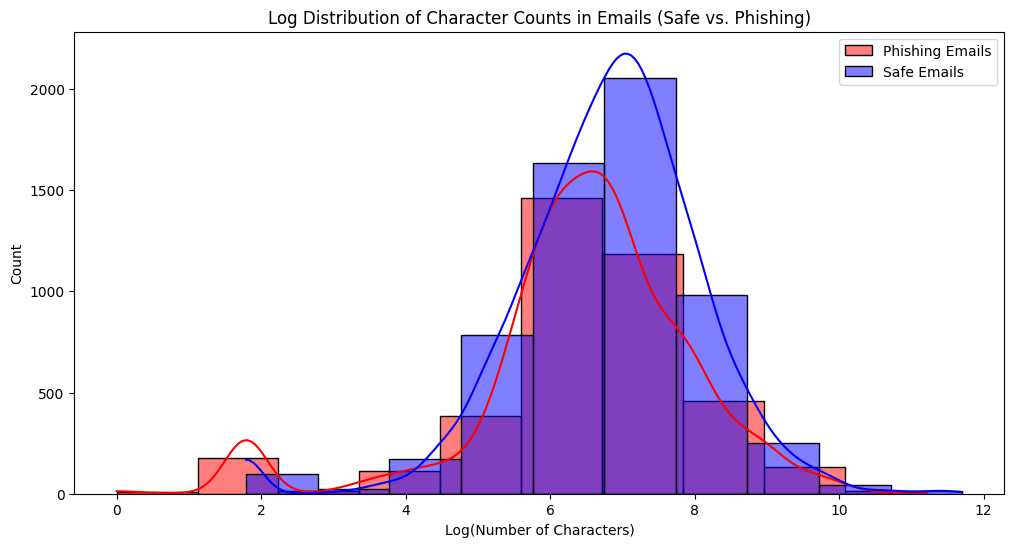

In [31]:
plt.figure(figsize=(12, 6))
df['log_num_characters'] = np.log1p(df['num_characters'])
sns.histplot(df[df['target'] == 0]['log_num_characters'], bins=10, label='Phishing Emails', color='red', kde=True)
sns.histplot(df[df['target'] == 1]['log_num_characters'], bins=10, label='Safe Emails', color='blue', kde=True)
plt.xlabel("Log(Number of Characters)")
plt.ylabel("Count")
plt.title("Log Distribution of Character Counts in Emails (Safe vs. Phishing)")
plt.legend()
plt.show()

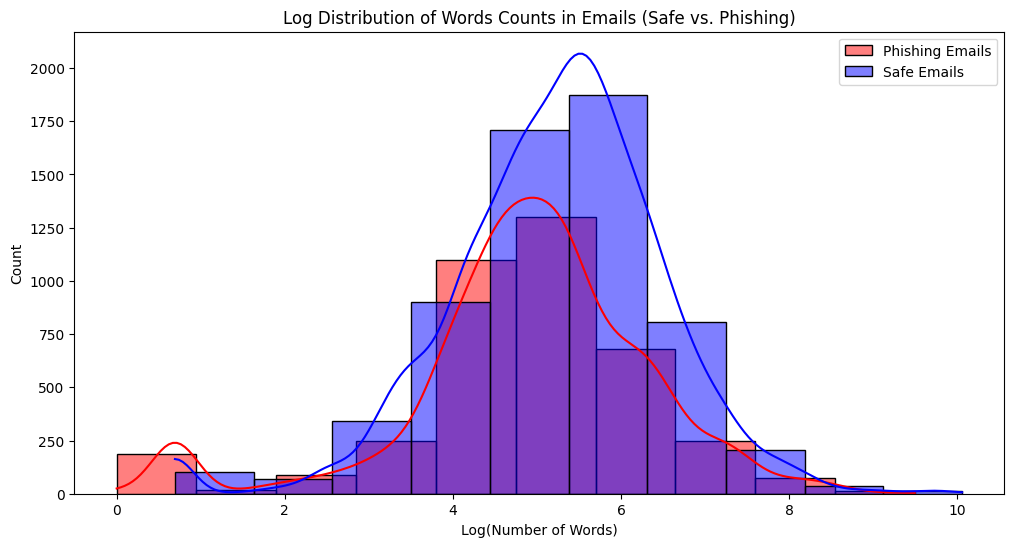

In [32]:
plt.figure(figsize=(12, 6))
df['log_num_words'] = np.log1p(df['num_words'])
sns.histplot(df[df['target'] == 0]['log_num_words'], bins=10, label='Phishing Emails', color='red', kde=True)
sns.histplot(df[df['target'] == 1]['log_num_words'], bins=10, label='Safe Emails', color='blue', kde=True)
plt.xlabel("Log(Number of Words)")
plt.ylabel("Count")
plt.title("Log Distribution of Words Counts in Emails (Safe vs. Phishing)")
plt.legend()
plt.show()

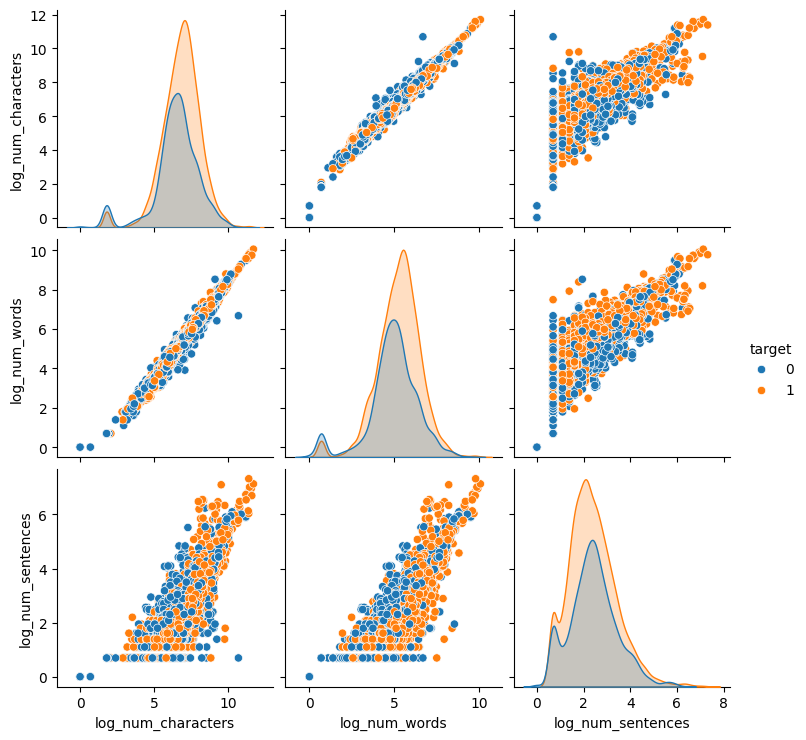

In [35]:
df['log_num_characters'] = np.log1p(df['num_characters'])
df['log_num_words'] = np.log1p(df['num_words'])
df['log_num_sentences'] = np.log1p(df['num_sentences'])
selected_columns = ['log_num_characters', 'log_num_words', 'log_num_sentences', 'target']
sns.pairplot(df[selected_columns], hue='target')
plt.show()

<Axes: >

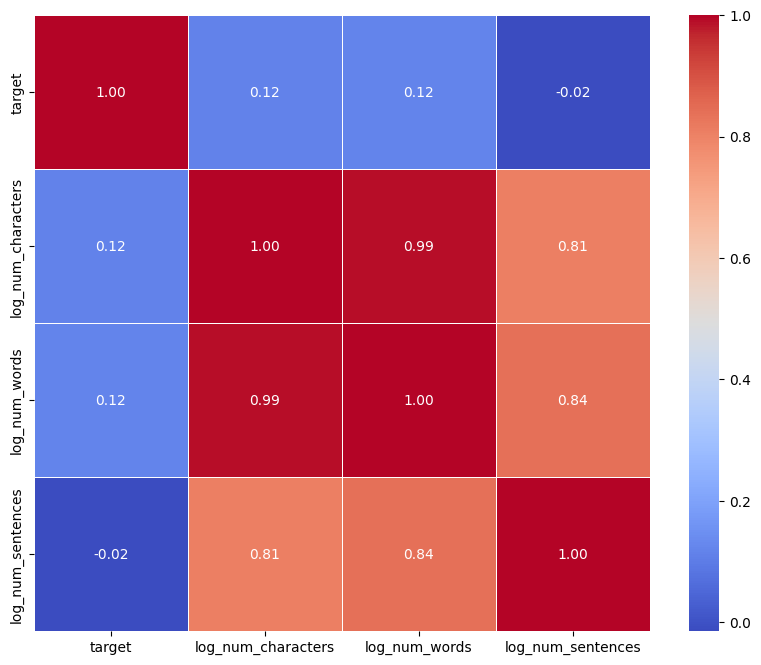

In [36]:
log_columns = ['target','log_num_characters', 'log_num_words', 'log_num_sentences']
correlation_matrix = df[log_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=.5)


**Observations:**

Safe emails: There is a tendency towards shorter character counts.

Phishing emails: The red bars are spread out more, suggesting a wider range of character counts in phishing emails. There might be a higher proportion of phishing emails with both very low and very high character counts compared to safe emails.

The heatmap suggests that the number of words, characters and sentences are strongly correlated.

# 3. Data Preprosessing:
*   **Lower Case:** I will first convert to lowercase to ensure consistency in text representation, as uppercase and lowercase versions of the same word may be treated differently by machine learning models.
*   **Tokenization:** Tokenization will break down text into individual words or tokens, allowing each word to be analyzed separately. Eg. \
Original Text: "The quick brown fox jumps over the lazy dog."\
Tokens: ["The", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"]
*   **Removing special characters:** Special characters such as punctuation marks and symbols will be removed from the text. This helps in reducing noise and improving the efficiency of subsequent text processing tasks.
*   **Removing stop words and punctuation:** Commonly occurring words known as stop words (e.g., "and", "the", "is") and punctuation marks will be removed from the text as they often carry little semantic meaning and can be considered noise.
*  **Stemming:** Stemming reduces words to their root form, allowing different variations of the same word to be treated as the same token. Eg. \
Original Text: "Running, runs, ran" \
Stemmed Text: "Run"

In [38]:
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []

    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

df['transformed_text'] = df['text'].apply(transform_text)
df.head()

,text,target,num_characters,num_words,num_sentences,log_num_characters,log_num_words,log_num_sentences,transformed_text
0,"Once upon a time, Harri wrote :> Title page ha...",1,772,120,3,6.650279,4.795791,1.386294,upon time harri wrote titl page login screen c...
1,new books : generative studies we would like t...,1,2366,491,22,7.769379,6.198479,3.135494,new book gener studi would like bring attent t...
2,new book : japanese linguistics japanese lingu...,1,1155,216,12,7.052721,5.379897,2.564949,new book japanes linguist japanes linguist ham...
3,renewal notice for your domain name ( s ) dear...,1,3025,637,41,8.014997,6.458338,3.737670,renew notic domain name dear regist com subscr...
4,hot stock tip your broker won ' t share now th...,0,8813,1657,64,9.084097,7.413367,4.174387,hot stock tip broker share oi ga enter long te...


Now I will create two word clouds, one of phishing email text and another of safe email text. This will give me am idea of the most frequent words used in each category.

In [42]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

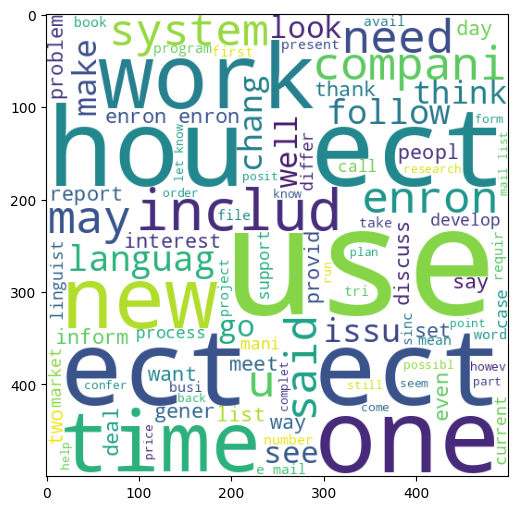

In [43]:
safe_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(safe_wc)

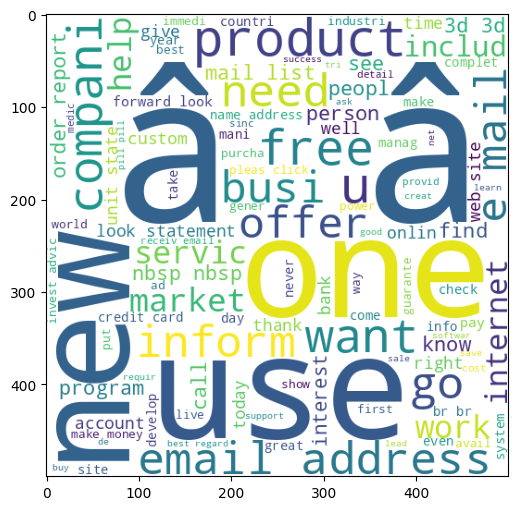

In [40]:
phishing_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(phishing_wc)

Next, I have created a corpus and common word histogram for both phishing and safe emails to analyze the frequency and distribution of words within each category. I get insights into the language used in both types of emails and this helps to inform feature selection and model training for classification.

In [49]:
phishing_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        phishing_corpus.append(word)
len(phishing_corpus)

604243

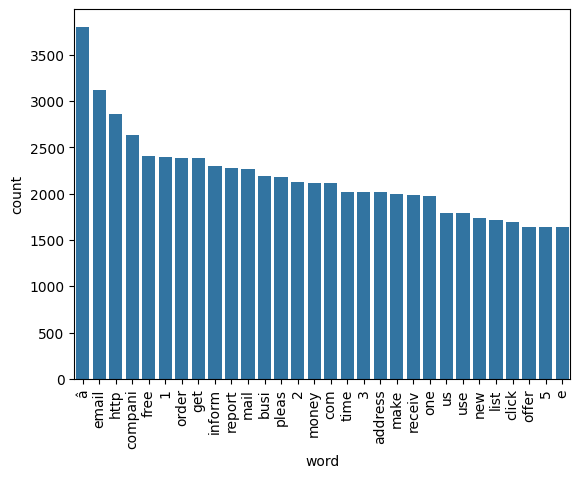

In [51]:
word_counts = Counter(phishing_corpus)
phishing_common_words = pd.DataFrame(word_counts.most_common(30), columns=['word', 'count'])
sns.barplot(x='word', y='count', data=phishing_common_words)
plt.xticks(rotation='vertical')
plt.show()

In [53]:
safe_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        safe_corpus.append(word)
len(safe_corpus)

1105292

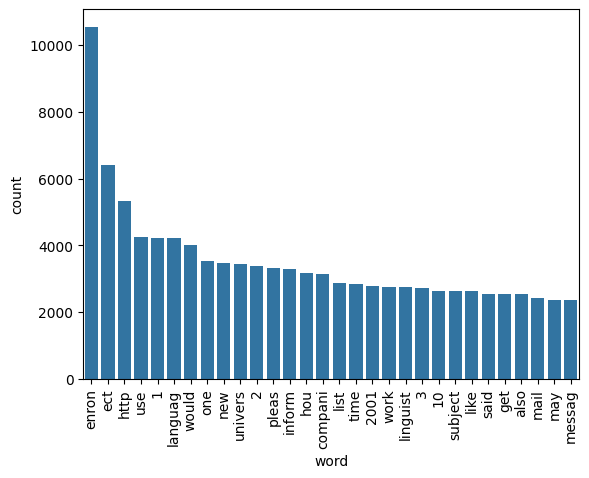

In [54]:
word_counts = Counter(safe_corpus)
safe_common_words = pd.DataFrame(word_counts.most_common(30), columns=['word', 'count'])
sns.barplot(x='word', y='count', data=safe_common_words)
plt.xticks(rotation='vertical')
plt.show()

# 4. Model Bulding

Next, I transformed the preprocessed text data into numerical features using TF-IDF vectorization with a maximum of 3000 features. This process converted the text data into a matrix format suitable for machine learning algorithms. I split the dataset into training and testing sets using an 80-20 split ratio and initialized several Naive Bayes classifiers along with Support Vector Machine, Logistic Regression, KNeighborsClassifier, Random Forest, AdaBoost, Gradient Boosting, and XGBoost classifiers.

Using k-fold cross-validation with 10 folds, I evaluated the performance of the Naive Bayes classifiers. This technique allowed me to train and test the models multiple times, ensuring robustness of the results. Then, I assessed the performance of the other classifiers using 5-fold cross-validation, calculating accuracy and precision scores for each model. Finally, I compiled the results into a DataFrame, sorting the models based on their precision scores in descending order to identify the most effective classifier for the task.

In [59]:
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
X.shape
y = df['target'].values

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [62]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [69]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
models = {'Gaussian Naive Bayes': gnb, 'Multinomial Naive Bayes': mnb, 'Bernoulli Naive Bayes': bnb}

for name, model in models.items():
    y_pred_cv = cross_val_predict(model, X, y, cv=kf)
    accuracy = accuracy_score(y, y_pred_cv)
    precision = precision_score(y, y_pred_cv)
    cm = confusion_matrix(y, y_pred_cv)

    print(f"\n{name} Results (Cross-Validation):")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Confusion Matrix:\n{cm}")



Gaussian Naive Bayes Results (Cross-Validation):
Accuracy: 0.9216
Precision: 0.9494966729227095
Confusion Matrix:
[[3651  296]
 [ 488 5565]]

Multinomial Naive Bayes Results (Cross-Validation):
Accuracy: 0.9517
Precision: 0.9609400860642171
Confusion Matrix:
[[3711  236]
 [ 247 5806]]

Bernoulli Naive Bayes Results (Cross-Validation):
Accuracy: 0.8895
Precision: 0.9862421383647799
Confusion Matrix:
[[3877   70]
 [1035 5018]]


In [75]:
svc = SVC(kernel='sigmoid', gamma=1.0)
mnb = MultinomialNB()
knc =  KNeighborsClassifier()
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [76]:
clfs = {
    'SVC' : svc,
    'NB': mnb,
    'kn': knc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [77]:
cv_accuracy = {}
cv_precision = {}

for clf_name, clf in clfs.items():
    y_pred_cv = cross_val_predict(clf, X, y, cv=5)

    acc = accuracy_score(y, y_pred_cv)
    cv_accuracy[clf_name] = acc

    prec = precision_score(y, y_pred_cv)
    cv_precision[clf_name] = prec

    print(f"{clf_name}: Accuracy: {acc:.4f}, Precision: {prec:.4f}")

SVC: Accuracy: 0.9619, Precision: 0.9773
KN: Accuracy: 0.5201, Precision: 0.9929
NB: Accuracy: 0.9506, Precision: 0.9596
LR: Accuracy: 0.9526, Precision: 0.9691
RF: Accuracy: 0.9547, Precision: 0.9715
AdaBoost: Accuracy: 0.9086, Precision: 0.9521
GBDT: Accuracy: 0.8865, Precision: 0.8613
xgb: Accuracy: 0.9484, Precision: 0.9706


In [81]:
performance_df = pd.DataFrame({'Algorithm': list(clfs.keys()),
                               'Accuracy': list(cv_accuracy.values()),
                               'Precision': list(cv_precision.values())})

# Sort DataFrame by Precision column in descending order
performance_df = performance_df.sort_values('Precision', ascending=False)

# Print the DataFrame
print(performance_df)

  Algorithm  Accuracy  Precision
1        KN    0.5201   0.992925
0       SVC    0.9619   0.977280
4        RF    0.9547   0.971539
7       xgb    0.9484   0.970593
3        LR    0.9526   0.969060
2        NB    0.9506   0.959649
5  AdaBoost    0.9086   0.952138
6      GBDT    0.8865   0.861299


The cross-validation results for various classifiers revealed key insights into their performance in detecting phishing emails. Gaussian Naive Bayes showed strong accuracy at 92.16% and precision at 94.95%, with moderate classification errors. Multinomial Naive Bayes excelled with 95.17% accuracy and 96.09% precision, demonstrating fewer errors. Bernoulli Naive Bayes, despite its highest precision of 98.62%, had a lower accuracy of 88.95%, indicating conservative classification. SVM with a sigmoid kernel was impressive, achieving 96.19% accuracy and 97.73% precision. In contrast, k-Nearest Neighbors performed poorly in accuracy at 52.01% but had high precision. Logistic Regression, Random Forest, and XGBoost all displayed robust performance with accuracies around 95% and precision near 97%. AdaBoost, with 90.86% accuracy and lower precision, and Gradient Boosting at 88.65% accuracy and 86.13% precision, lagged behind. These metrics highlight each model's strengths and guide the selection of the most effective classifier for phishing email detection.

To visualize the performance of our classifiers effectively, I reshaped the performance DataFrame using the `melt` function, combining the 'Accuracy' and 'Precision' columns into a single 'Metric' column. This transformation allowed me to plot both metrics side by side for each algorithm. Using Seaborn's `catplot` function, I created a bar chart where the x-axis represents the different algorithms, the y-axis represents the score, and the hue differentiates between accuracy and precision. Setting the y-axis limits between 0.5 and 1.0 ensured clearer visibility of score differences, and rotating the x-axis labels improved readability. This comprehensive visualization helps in quickly identifying which algorithms perform best in terms of both accuracy and precision.

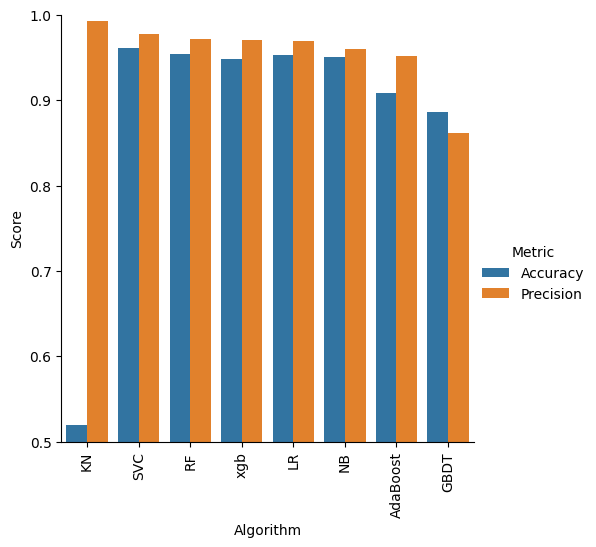

In [86]:
performance_df_melted = performance_df.melt(id_vars='Algorithm', var_name='Metric', value_name='Score')

# Plot the graph
sns.catplot(x='Algorithm', y='Score', hue='Metric', data=performance_df_melted, kind='bar', height=5)
plt.ylim(0.5, 1.0)
plt.xticks(rotation='vertical')
plt.show()

To improve our model's performance, I used a Voting Classifier that combines the strengths of different algorithms for more accurate predictions. I chose three classifiers: Support Vector Classifier (SVC) with a sigmoid kernel, Multinomial Naive Bayes (MNB), and Logistic Regression (LR) with L1 regularization. The Voting Classifier uses the 'soft' voting method, which considers the predicted probabilities from each classifier instead of just the final predicted class. I trained the Voting Classifier on the training data (`X_train` and `y_train`) and then made predictions on the test data (`X_test`). Finally, I evaluated the model by calculating its accuracy and precision, which showed how well the combined model performed. This approach uses different models together to get better results.

In [93]:
svc = SVC(kernel='sigmoid', gamma=1.0, probability=True)
mnb = MultinomialNB()
lrc = LogisticRegression(solver='liblinear', penalty='l1')
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('lr', lrc)], voting='soft')
voting.fit(X_train,y_train)
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9655
Precision 0.9719387755102041


To further improve my model's performance, I used a Stacking Classifier, which combines multiple classifiers to make better predictions. I chose the same three base models: SVC, MNB, LR. These models work together, and their predictions are combined by a RandomForestClassifier, which is the final model. After training this combined model on my training data, I tested it on my test data and got great results: 96.4% accuracy and 98.1% precision. This approach uses the strengths of different models to achieve high accuracy and precision.

In [96]:
estimators=[('svm', svc), ('nb', mnb), ('lr', lrc)]
final_estimator=RandomForestClassifier()
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.964
Precision 0.9808861859252823


These lines of code use the pickle library to save our trained TF-IDF vectorizer (tfidf) and Multinomial Naive Bayes classifier (mnb) to disk. By serializing these objects into binary files (vectorizer.pkl and model.pkl), we can store them for later use without needing to retrain the models. This allows us to reuse the trained models in future sessions without the need to reprocess the data or retrain the models, saving time and resources.

In [98]:
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))